<a href="https://colab.research.google.com/github/silver380/ResNet-SOM-Clustering/blob/main/SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import resnet34
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, f1_score
import math
from tqdm import tqdm


from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

In [ ]:
# loading the train data
batch_size = 100
#drop_last=True
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True )

#loading the test data
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
test_dataloader = DataLoader(test_data,batch_size=batch_size, shuffle=True)
# You should define x_train and y_train

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
feature_extractor = resnet34(pretrained=True)
num_features = feature_extractor.fc.in_features

for param in feature_extractor.parameters():
    param.requires_grad = False

feature_extractor.fc = nn.Identity()
feature_extractor.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:

# Helper functions

# Data Normalisation
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

# # Euclidean distance
# def e_distance(x,y):
#   return distance.euclidean(x,y)

# Manhattan distance
def m_distance(x,y):
  return distance.cityblock(x,y)

def e_distance(x, y):
    return torch.sqrt(torch.sum((x - y) ** 2))

# def m_distance(x, y):
#     return torch.sum(torch.abs(x - y))

# Best Matching Unit search
def winning_neuron(data, som, num_rows, num_cols):
  winner = [0,0]
  # som = som.to(device)
  # data = data.to(device)
  shortest_distance = 10e7 # initialise with max distance
  for row in range(num_rows):
    for col in range(num_cols):
      if som[row][col] != None:
        
        distance = e_distance(som[row][col], data)
        if distance < shortest_distance: 
          shortest_distance = distance
          winner = [row,col]
  return winner

# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_distance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_distance)
  # neighbourhood_range = max_m_distance
  return learning_rate, neighbourhood_range

def dist_func(x):
  #guassian
  sig = 2 #?
  return np.exp(-np.power(x , 2.) / (2 * np.power(sig, 2.)))
  

In [ ]:
y_data_list = []
data_list = []
for x_train, y_train in train_dataloader:
  x_train, y_train = x_train.to(device), y_train.to(device)

  features = feature_extractor(x_train)
  features = minmax_scaler(features.cpu().numpy())
  features = torch.from_numpy(features)
  data_list.append(features)

  y_data_list.append(y_train)

print(len(y_data_list))
print(len(data_list))

500
500


In [ ]:
y_test_list = []
data_test_list = []
for x_test, y_test in test_dataloader:
  x_test, y_test = x_test.to(device), y_test.to(device)

  features = feature_extractor(x_test)
  features = minmax_scaler(features.cpu().numpy())
  features = torch.from_numpy(features)
  data_test_list.append(features)

  y_test_list.append(y_test)

print(len(y_test_list))
print(len(data_test_list))

100
100


In [ ]:
# hyperparameters
num_rows = 10
num_cols = 10
max_m_dsitance = 4
max_learning_rate = 0.6
# max_steps = int(7.5*10e3)
max_steps = 20
is_2d = False


In [ ]:

# initialising self-organising map
num_dims = data_list[0].shape[1] # numnber of dimensions in the input data
if is_2d:
  np.random.seed(40)
  som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction
  som[3][0] = None
  som[3][2] = None
  som = torch.from_numpy(som)
else:
  np.random.seed(40)
  som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction
  som = torch.from_numpy(som)

In [ ]:
epochs = 20

for epoch in range(epochs):
    for features in tqdm(data_list, desc=f"Epoch {epoch+1}", colour="blue"):
        # features.to(device)
        # som = som.to(device)

        # start training iterations
        for i in range(features.shape[0]):
          learning_rate, neighbourhood_range = decay(epoch, epochs, max_learning_rate, max_m_dsitance)

          # rand_data = np.random.randint(0,high=features.shape[0]) # random index of traing data
          winner = winning_neuron(features[i], som, num_rows, num_cols)
          for row in range(num_rows):
            for col in range(num_cols):
              if som[row][col] != None:
                dist = m_distance([row,col],winner)
                if dist <= neighbourhood_range:
                  som[row][col] += learning_rate * dist_func(dist) * (features[i]-som[row][col]) #update neighbour's weight

            # print("SOM training completed")

Epoch 2:  54%|█████▍    | 272/500 [01:15<01:03,  3.60it/s]


KeyboardInterrupt: ignored

In [ ]:
# collecting labels
map = np.empty(shape=(num_rows, num_cols), dtype=object)
for row in range(num_rows):
  for col in range(num_cols):
    if som[row][col] != None:
      map[row][col] = [] # empty list to store the label

for i, features in enumerate(data_list):


  # features = feature_extractor(x_train)
  # features = minmax_scaler(features)
  # features = torch.from_numpy(features)
  label_data = y_data_list[i].cpu().numpy()
  
  
  for t in range(features.shape[0]):
    winner = winning_neuron(features[t], som, num_rows, num_cols)
    map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

In [ ]:
# construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    if som[row][col] != None:
      label_list = map[row][col]
      if len(label_list)==0:
        label = 11
      else:
        label = max(label_list, key=label_list.count)
      label_map[row][col] = label


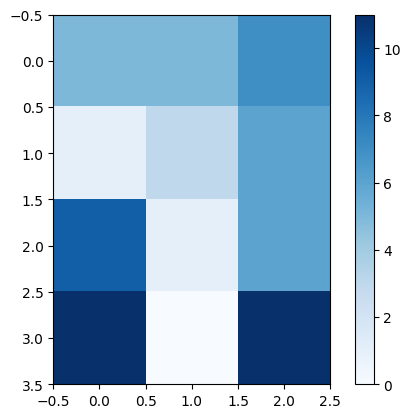

In [ ]:
# title = ('Iteration ' + str(max_steps))
# cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(label_map, cmap='Blues')
plt.colorbar()
# plt.title(title)
plt.show()

In [ ]:

# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node
# x_test, y_test = test_dataloader
sum_acc = 0
n = 0
for i, features in enumerate(data_test_list):


  # features = feature_extractor(x_test)
  # features = minmax_scaler(features)
  # features = torch.from_numpy(features)
  winner_labels = []

  for t in range(features.shape[0]):
    winner = winning_neuron(features[t], som, num_rows, num_cols)
    row = winner[0]
    col = winner[1]
    predicted = label_map[row][col]
    winner_labels.append(predicted)
  acc = accuracy_score(y_test_list[i].cpu().numpy(), winner_labels)
  sum_acc += acc
  n += 1
  print("Accuracy: ",acc)

print("Total Accuracy: ", sum_acc /n)

Accuracy:  0.28
Accuracy:  0.33
Accuracy:  0.31
Accuracy:  0.35
Accuracy:  0.35
Accuracy:  0.42
Accuracy:  0.39
Accuracy:  0.45
Accuracy:  0.33
Accuracy:  0.33
Accuracy:  0.34
Accuracy:  0.28
Accuracy:  0.35
Accuracy:  0.31
Accuracy:  0.33
Accuracy:  0.38
Accuracy:  0.38
Accuracy:  0.35
Accuracy:  0.38
Accuracy:  0.28
Accuracy:  0.31
Accuracy:  0.34
Accuracy:  0.32
Accuracy:  0.32
Accuracy:  0.32
Accuracy:  0.38
Accuracy:  0.33
Accuracy:  0.4
Accuracy:  0.35
Accuracy:  0.34
Accuracy:  0.38
Accuracy:  0.33
Accuracy:  0.39
Accuracy:  0.4
Accuracy:  0.38
Accuracy:  0.39
Accuracy:  0.35
Accuracy:  0.24
Accuracy:  0.31
Accuracy:  0.35
Accuracy:  0.4
Accuracy:  0.33
Accuracy:  0.37
Accuracy:  0.36
Accuracy:  0.31
Accuracy:  0.26
Accuracy:  0.24
Accuracy:  0.32
Accuracy:  0.49
Accuracy:  0.47
Accuracy:  0.31
Accuracy:  0.33
Accuracy:  0.26
Accuracy:  0.24
Accuracy:  0.36
Accuracy:  0.39
Accuracy:  0.3
Accuracy:  0.35
Accuracy:  0.44
Accuracy:  0.38
Accuracy:  0.35
Accuracy:  0.29
Accuracy:  0